# Auto PiReps Data Visualizer
This notebook reads .NED files from the AATR hardware for data science


In [1]:
#import libraries that we need for graphing
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sg

#This line makes the graphs interactive
%matplotlib notebook

In [2]:
filename = "data.ned"
datapath = "data/"

xl_odr = 6600 #Sa/s
gyro_odr = 409 #Sa/s

fs_gyro = 250 #dps
fs_xl = 4 #g

In [3]:
#Functions to help with data conversion
def convert_gyro(b1, b2):
    raw = int.from_bytes([b1,b2], byteorder='little', signed=True)
    return (raw/2**15 * fs_gyro)

#Functions to help with data conversion
def convert_xl(b1, b2):
    raw = int.from_bytes([b1,b2], byteorder='little', signed=True)
    return (raw/2**15 * fs_xl)

def printlines(data):
    for i in range(int(len(data)/7)):
        print([hex(j) for j in data[i*7:i*7+7]])

## Read in the .Ned File

In [4]:
#Open the file
with open(datapath + filename, mode='rb') as file: # b is important -> binary
    
    byte_idx = 0;
    zero_count = 0;
    line_count = 0;
    
    bytearr = np.array(list(file.read()))
        
    #Estimate the number of readings from the file size
    filesize = len(bytearr)
    xl_readings = int((filesize / 7) * xl_odr / (xl_odr + gyro_odr) * 1.1)
    gyro_readings = int((filesize / 7) * gyro_odr / (xl_odr + gyro_odr) * 1.1)
                        
    #Use those estimates to initialize a numpy array
    xl_data = np.zeros((xl_readings, 3))
    gyro_data = np.zeros((gyro_readings, 3))
    
    xl_idx = 0
    gyro_idx = 0
    
   
    
    while (byte_idx < filesize):
        if(bytearr[byte_idx] >> 3 == 0x01): #Gyroscope NC
            gyro_data[gyro_idx,0] = convert_gyro(bytearr[byte_idx + 1], bytearr[byte_idx + 2])
            gyro_data[gyro_idx,1] = convert_gyro(bytearr[byte_idx + 3], bytearr[byte_idx + 4])
            gyro_data[gyro_idx,2] = convert_gyro(bytearr[byte_idx + 5], bytearr[byte_idx + 6])
            byte_idx += 7
            line_count += 1
            gyro_idx += 1
        elif(bytearr[byte_idx] >> 3 == 0x02): #Accelerometer NC
            xl_data[xl_idx,0] = convert_xl(bytearr[byte_idx + 1], bytearr[byte_idx + 2])
            xl_data[xl_idx,1] = convert_xl(bytearr[byte_idx + 3], bytearr[byte_idx + 4])
            xl_data[xl_idx,2] = convert_xl(bytearr[byte_idx + 5], bytearr[byte_idx + 6])
            byte_idx += 7
            line_count += 1
            xl_idx += 1
        else:
            print("Invalid Tag")
            byte_idx += 7
            
    #trim the data
    xl_data = xl_data[:xl_idx]
    gyro_data = gyro_data[:gyro_idx]
            

Invalid Tag
Invalid Tag
Invalid Tag
Invalid Tag
Invalid Tag
Invalid Tag


<IPython.core.display.Javascript object>


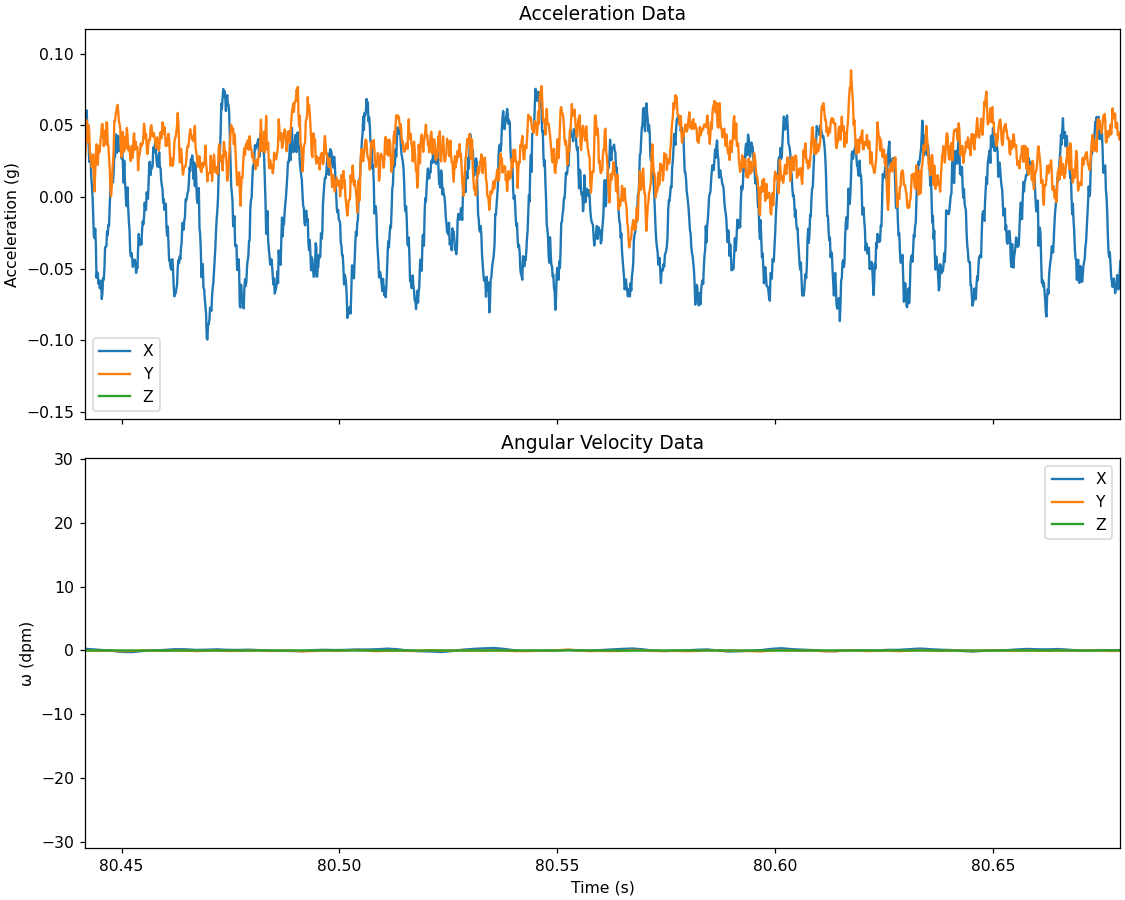

In [5]:
def plot_xl():
    xl_plot = plt.figure(figsize=(10,5))
    tvec = np.arange(0,len(xl_data)/xl_odr, 1/xl_odr)
    
    plt.plot(tvec, xl_data[:,0])
    plt.plot(tvec, xl_data[:,1])
    plt.plot(tvec, xl_data[:,2])
    
    plt.legend(['X', 'Y', 'Z'])
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (g)')
    
    plt.title('Acceleration Data')
    
    plt.show()
    
def plot_gyro():
    gyro_plot = plt.figure(figsize=(10,5))
    tvec = np.arange(0,len(gyro_data)/gyro_odr, 1/gyro_odr)
    
    plt.plot(tvec, gyro_data[:,0])
    plt.plot(tvec, gyro_data[:,1])
    plt.plot(tvec, gyro_data[:,2])
    
    plt.legend(['X', 'Y', 'Z'])
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (dpm)')
    
    plt.title('Angular Velocity Data')
    
    plt.show()
    
def plot_combined():
    data_plot, axs = plt.subplots(2, 1, figsize=(10,8), constrained_layout=True, sharex=True)
    
    a_tvec = np.arange(0,len(xl_data)/xl_odr, 1/xl_odr)
    
    axs[0].plot(a_tvec, xl_data[:,0])
    axs[0].plot(a_tvec, xl_data[:,1])
    axs[0].plot(a_tvec, xl_data[:,2])
    
    axs[0].legend(['X', 'Y', 'Z'])
    axs[0].set_ylabel('Acceleration (g)')
    
    axs[0].set_title('Acceleration Data')
    
    g_tvec = np.arange(0,len(gyro_data)/gyro_odr, 1/gyro_odr)
    
    axs[1].plot(g_tvec, gyro_data[:,0])
    axs[1].plot(g_tvec, gyro_data[:,1])
    axs[1].plot(g_tvec, gyro_data[:,2])
    
    axs[1].legend(['X', 'Y', 'Z'])
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('ω (dpm)')
    
    axs[1].set_title('Angular Velocity Data')
    
    plt.show()
    
plot_combined()

In [16]:
#Downsample (yikes!)
xl_ds = sg.decimate(xl_data[72600:,0], 10)

In [17]:
#Spectrogram
f, t, Sxx = sg.spectrogram(xl_ds, xl_odr/10)

<IPython.core.display.Javascript object>


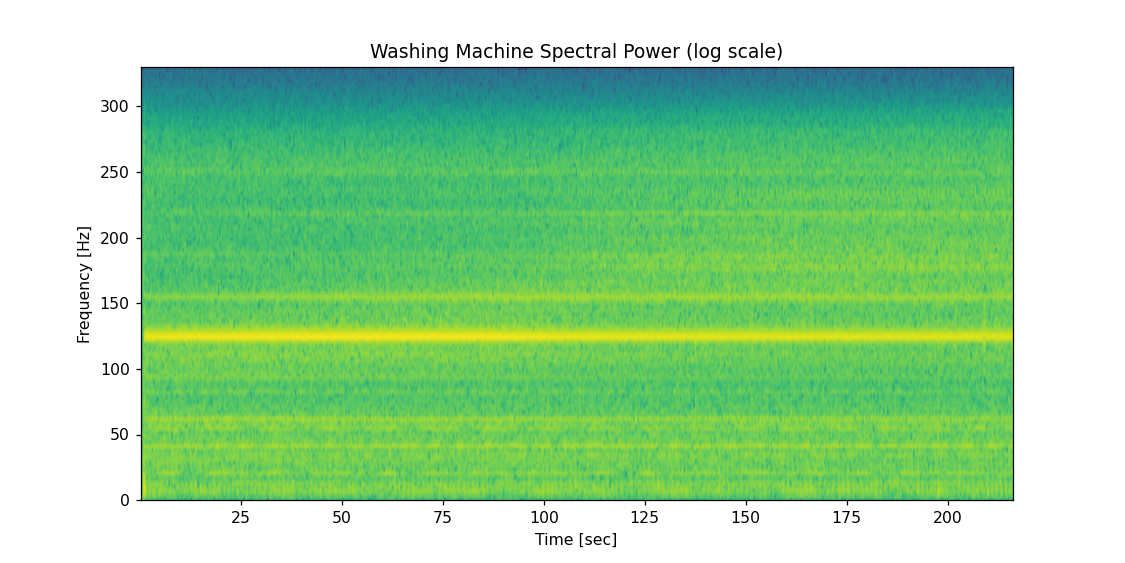

In [20]:
spectrogram = plt.figure(figsize=(10,5))
plt.pcolormesh(t, f, np.log(Sxx), shading='gouraud')
plt.title("Washing Machine Spectral Power (log scale)")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()